<a href="https://colab.research.google.com/github/calebarr/AIS/blob/main/AIS_Downloader_TeamShared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\ndownload_ais_data(\n    start_date_str="2020-01-01",\n    end_date_str="2020-01-02",\n    save_folder="/content/drive/My Drive/SIADS_593/assets/raw_data"\n)\n'

In [9]:
!ls -lh "/content/drive/My Drive/SIADS_593/assets/raw_data"


total 0


In [20]:
def process_zip_in_chunks(zip_path, chunksize=100_000):

    all_cleaned_chunks = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
        if not csv_files:
            return pd.DataFrame()

        with zip_ref.open(csv_files[0]) as f:
            reader = pd.read_csv(f, chunksize=chunksize)
            for chunk in reader:
                cleaned = extract_first_arrivals_anywhere(chunk)
                all_cleaned_chunks.append(cleaned)

    return pd.concat(all_cleaned_chunks, ignore_index=True)


In [21]:
def extract_first_arrivals_anywhere(df):
    # Filter by relevant vessel types
    df = df[
        df["VesselType"].isin(range(70, 90)) | df["VesselType"].isin([30, 52])
    ].copy()

    # Drop rows with missing or invalid coordinates
    df = df.dropna(subset=["LAT", "LON"])
    df = df[(df["LAT"] != 0) & (df["LON"] != 0)]

    # Convert timestamps
    df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors='coerce')

    df = df.dropna(subset=["BaseDateTime"])

    # Filter for ships that are of Status 1 & 5 (Anchored)
   #if "Status" in df.columns:
   #  df = df[df["Status"].isin([1, 5])]

    """
    Working on cleaning this section
    """
    # Drop all the columns that are not need
    columns_to_drop = ["SOG", "COG", "Heading", "IMO", "VesselName", "Length", "Width", "TransceiverClass", "Cargo", "CallSign", "Draft"]
    existing_cols = [col for col in columns_to_drop if col in df.columns]

    df = df.drop(columns=existing_cols)

    # End of cleaning

    # Sort and get the first ping per MMSI
    first_arrivals = (
        df.sort_values(["MMSI", "BaseDateTime"])
          .drop_duplicates("MMSI", keep="first")
    )

    # Assign port names
    return assign_port_names(first_arrivals)


In [22]:
def assign_port_names(df, buffer=1.3):
    PORT_REGIONS = {
        "Los Angeles": (33.6, 33.9, -118.5, -118.0),
        "Long Beach": (33.7, 33.9, -118.25, -118.15),
        "Oakland": (37.7, 37.85, -122.35, -122.2),
        "Seattle": (47.5, 47.7, -122.4, -122.2),
        "New York": (40.6, 40.8, -74.1, -73.9),
        "Norfolk": (36.8, 37.1, -76.4, -76.2),
        "Savannah": (32.0, 32.2, -81.2, -80.8),
        "Charleston": (32.7, 32.9, -80.0, -79.8),
        "Miami": (25.75, 25.85, -80.2, -80.0),
        "Port Everglades": (26.05, 26.1, -80.15, -80.1),
        "Baltimore": (39.2, 39.3, -76.6, -76.5),
        "Philadelphia": (39.9, 40.0, -75.2, -75.1),
        "Houston": (29.6, 29.8, -95.2, -94.8),
        "New Orleans": (29.9, 30.1, -90.1, -89.9),
        "Jacksonville": (30.3, 30.5, -81.7, -81.3),
        "San Diego": (32.7, 32.8, -117.2, -117.1),
        "Boston": (42.3, 42.4, -71.1, -70.9),
        "Anchorage": (61.1, 61.3, -149.95, -149.8),
        "Honolulu": (21.3, 21.4, -157.9, -157.8),
        "Portland": (45.6, 45.7, -122.7, -122.6),
        "Puerto Rico": (18.2, 18.3, -66.3, -66.2),
        "Tacoma": (47.2, 47.4, -122.55, -122.35),
        "Port Arthur": (29.85, 29.95, -93.95, -93.85),
        "Beaumont": (30.0, 30.1, -94.15, -94.05),
        "Corpus Christi": (27.75, 27.9, -97.45, -97.25),
        "Baton Rouge": (30.4, 30.5, -91.25, -91.15),
        "Mobile": (30.6, 30.7, -88.1, -88.0),
        "Tampa": (27.9, 28.0, -82.5, -82.4),
        "San Francisco": (37.75, 37.85, -122.45, -122.3),
        "Wilmington (DE)": (39.7, 39.75, -75.55, -75.5),
        "Camden (NJ)": (39.9, 39.95, -75.1, -75.05),
        "Providence": (41.7, 41.8, -71.45, -71.35),
        "Unknown": (None, None, None, None),  # fallback
    }

    def get_port_name(lat, lon):
        for port, bounds in PORT_REGIONS.items():
            if None in bounds:
                continue  # skip 'Unknown'
            min_lat, max_lat, min_lon, max_lon = bounds
            if (min_lat - buffer) <= lat <= (max_lat + buffer) and \
               (min_lon - buffer) <= lon <= (max_lon + buffer):
                return port
        return "Unknown"

    df["Port Name"] = df.apply(lambda row: get_port_name(row["LAT"], row["LON"]), axis=1)
    return df



In [23]:
def run_ais_pipeline(start_date_str, end_date_str, raw_data_dir, cleaned_csv_path):
    from datetime import datetime, timedelta

    # Step 1: Download AIS zip files
    download_ais_data(start_date_str, end_date_str, raw_data_dir)

    # Step 2: Build list of zip paths from date range
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    date_range = [
        (start_date + timedelta(days=i)).strftime("AIS_%Y_%m_%d.zip")
        for i in range((end_date - start_date).days + 1)
    ]

    zip_paths = [
        os.path.join(raw_data_dir, filename)
        for filename in date_range
        if os.path.exists(os.path.join(raw_data_dir, filename))
    ]

    if not zip_paths:
        print("No matching zip files found. Exiting.")
        return

    # Step 3: Process and concatenate
    print(f"Processing {len(zip_paths)} zip files...")
    vessel_data = pd.concat(
        [process_zip_in_chunks(path) for path in zip_paths],
        ignore_index=True
    )

    # Step 4: Drop rows where port is 'Unknown'
    cleaned_df = vessel_data[vessel_data['Port Name'] != 'Unknown'].copy()

    # Step 5: Save the cleaned data
    os.makedirs(os.path.dirname(cleaned_csv_path), exist_ok=True)
    cleaned_df.to_csv(cleaned_csv_path, index=False)

    print(f" Cleaned data saved to: {cleaned_csv_path}")
    print("Shape of the cleaned data:", cleaned_df.shape)


In [25]:
run_ais_pipeline(
    start_date_str="2020-01-01",
    end_date_str="2020-01-02",
    raw_data_dir="/content/drive/My Drive/SIADS_593/assets/raw_data",
    cleaned_csv_path="/content/drive/My Drive/SIADS_593/assets/cleaned_data/first_arrivals_cleaned.csv"
)


Files will be saved to: /content/drive/My Drive/SIADS_593/assets/raw_data
Already downloaded: AIS_2020_01_01.zip
Already downloaded: AIS_2020_01_02.zip
📦 Processing 2 zip files...


<ipython-input-21-e0d6979b6baf>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"], errors='coerce')


✅ Cleaned data saved to: /content/drive/My Drive/SIADS_593/assets/cleaned_data/first_arrivals_cleaned.csv
📊 Shape of the cleaned data: (182038, 7)


In [ ]:
import pandas as pd

vessel_data = pd.concat([
    process_zip_in_chunks("/content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_01_01.zip"),
    process_zip_in_chunks("/content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_01_02.zip")
])



<ipython-input-103-e0d6979b6baf>:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [ ]:
first_arrivals_df = extract_first_arrivals_anywhere(vessel_data)
first_arrivals_df["Port Name"].value_counts()



,count
Port Name,
Unknown,1285
Houston,222
New Orleans,174
Seattle,172
Boston,166
New York,98
Norfolk,97
Los Angeles,80
Miami,68


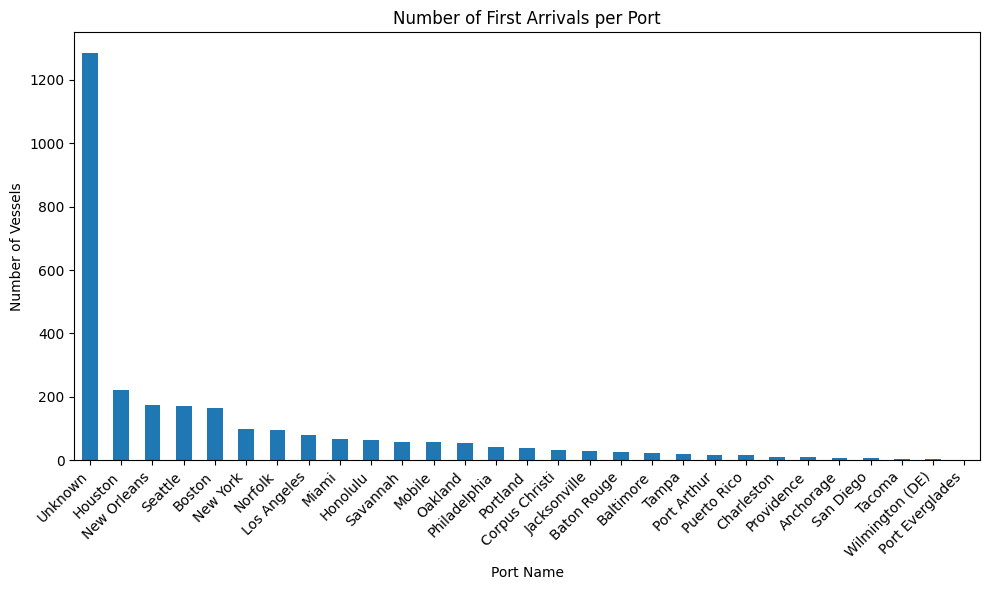

In [ ]:
# prompt: create bar chart

import matplotlib.pyplot as plt

# Assuming 'first_arrivals_df' is already created and contains the 'Port Name' column
if 'Port Name' in first_arrivals_df.columns:
    port_counts = first_arrivals_df["Port Name"].value_counts()

    plt.figure(figsize=(10, 6))
    port_counts.plot(kind='bar')
    plt.title('Number of First Arrivals per Port')
    plt.xlabel('Port Name')
    plt.ylabel('Number of Vessels')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("The DataFrame does not contain a 'Port Name' column to create the bar chart.")

In [ ]:
print(vessel_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 91490 entries, 0 to 46463
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   MMSI          91490 non-null  int64         
 1   BaseDateTime  91490 non-null  datetime64[ns]
 2   LAT           91490 non-null  float64       
 3   LON           91490 non-null  float64       
 4   VesselType    91490 non-null  float64       
 5   Status        91490 non-null  float64       
 6   Port Name     91490 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.6+ MB
None


In [ ]:
anchored_ships = vessel_data[vessel_data["Status"] == 5]
anchored_ships = vessel_data[vessel_data["Status"] == 1]
print(anchored_ships.head())



         MMSI        BaseDateTime       LAT        LON  VesselType  Status  \
4   210057000 2020-01-01 00:02:47  25.80055  -78.09210        70.0     1.0   
5   210159000 2020-01-01 00:06:25  25.80604  -78.05797        70.0     1.0   
8   211327410 2020-01-01 00:01:18  37.75225 -122.35440        70.0     1.0   
9   212122000 2020-01-01 00:00:55  29.99707  -90.43610        70.0     1.0   
11  212498000 2020-01-01 00:00:48  30.03903  -90.68842        70.0     1.0   

      Port Name  
4       Unknown  
5       Unknown  
8       Oakland  
9   New Orleans  
11  New Orleans  


In [ ]:
# Drop rows where 'Port Name' is 'Unknown'
cleaned_df = first_arrivals_df[first_arrivals_df['Port Name'] != 'Unknown'].copy()

# Define the path to save the cleaned CSV
cleaned_csv_path = "/content/drive/My Drive/SIADS_593/assets/cleaned_data/first_arrivals_cleaned.csv"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(cleaned_csv_path), exist_ok=True)

# Save the cleaned DataFrame to a new CSV file
cleaned_df.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned data saved to: {cleaned_csv_path}")
print("Shape of the cleaned data:", cleaned_df.shape)

Cleaned data saved to: /content/drive/My Drive/SIADS_593/assets/cleaned_data/first_arrivals_cleaned.csv
Shape of the cleaned data: (790, 7)


In [ ]:
print(f"Number of anchored ships: {len(anchored_ships)}")


Number of anchored ships: 37053


In [ ]:
anchored_by_port = anchored_ships["Port Name"].value_counts()
print(anchored_by_port)


Port Name
Unknown            8886
Houston            7603
New Orleans        5766
Los Angeles        2279
Oakland            1711
Corpus Christi     1521
Mobile             1295
Port Arthur        1250
Savannah           1140
New York            854
Seattle             752
San Diego           568
Norfolk             486
Philadelphia        478
Boston              446
Miami               389
Baton Rouge         341
Portland            275
Tampa               229
Charleston          228
Jacksonville        214
Tacoma              168
Honolulu            129
Baltimore            34
Wilmington (DE)      11
Name: count, dtype: int64


In [ ]:
#Start Check for duplicates

In [ ]:
# Checking for duplicate MMSi S (unique ship IDuigd)
first_arrivals = extract_first_arrivals_anywhere(vessel_data)

# Check for duplicates in MMSI
duplicates = first_arrivals[first_arrivals.duplicated("MMSI", keep=False)]

print(f"Number of duplicate MMSI entries: {len(duplicates)}")
if not duplicates.empty:
    print(duplicates)


Number of duplicate MMSI entries: 0


In [ ]:
# Check for full row duplicates
full_dupes = first_arrivals[first_arrivals.duplicated(keep=False)]
print(f"Duplicate full rows: {len(full_dupes)}")

# Optional: check that each MMSI is only listed once
assert first_arrivals["MMSI"].is_unique, "⚠️ Duplicate MMSIs found!"


Duplicate full rows: 0


In [ ]:
mmsi_counts = first_arrivals["MMSI"].value_counts()
print(mmsi_counts.head())

# Show MMSIs that appear more than once
print("MMSIs with multiple entries:")
print(mmsi_counts[mmsi_counts > 1])


MMSI
775093000    1
205700000    1
205706000    1
209017000    1
209393000    1
Name: count, dtype: int64
MMSIs with multiple entries:
Series([], Name: count, dtype: int64)


In [ ]:
#End of Check for Duplicates

In [ ]:
import plotly.express as px

# Sample 500 points to make rendering faster, or skip .sample() to show all
sample_df = first_arrivals_df.sample(n=500, random_state=42)

fig = px.scatter_geo(
    sample_df,
    lat='LAT',
    lon='LON',
    color='Port Name',
    hover_name='VesselType',
    title='First Arrivals: Vessel Locations by Port',
    projection="natural earth"
)

fig.update_layout(geo=dict(
    scope='world',
    showland=True,
    landcolor="lightgray",
))

fig.show()


In [ ]:
def process_zip_in_chunks_filtered(zip_path, chunksize=100_000):
    import zipfile, pandas as pd

    all_filtered_chunks = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        csv_files = [name for name in zip_ref.namelist() if name.endswith('.csv')]
        if not csv_files:
            return pd.DataFrame()

        with zip_ref.open(csv_files[0]) as f:
            reader = pd.read_csv(f, chunksize=chunksize)
            for chunk in reader:
                # Filter by relevant vessel types
                filtered_chunk = chunk[
                    chunk["VesselType"].isin(range(70, 90)) | chunk["VesselType"].isin([30, 52])
                ].copy()

                # Drop rows with missing or invalid coordinates
                filtered_chunk = filtered_chunk.dropna(subset=["LAT", "LON"])
                filtered_chunk = filtered_chunk[(filtered_chunk["LAT"] != 0) & (filtered_chunk["LON"] != 0)]

                # Convert timestamps
                filtered_chunk["BaseDateTime"] = pd.to_datetime(filtered_chunk["BaseDateTime"], errors='coerce')
                filtered_chunk = filtered_chunk.dropna(subset=["BaseDateTime"])

                all_filtered_chunks.append(filtered_chunk)

    return pd.concat(all_filtered_chunks, ignore_index=True)

In [ ]:
import pandas as pd

# Process each zip file to get filtered data
all_filtered_data = pd.concat([
    process_zip_in_chunks_filtered("/content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_01_01.zip"),
    process_zip_in_chunks_filtered("/content/drive/My Drive/SIADS_593/assets/raw_data/AIS_2020_01_02.zip")
])

# Now find the true first arrivals from the combined filtered data
first_arrivals_df = (
    all_filtered_data.sort_values(["MMSI", "BaseDateTime"])
    .drop_duplicates("MMSI", keep="first")
)

# Finally, assign port names to the first arrivals
first_arrivals_df = assign_port_names(first_arrivals_df)

# Now you can analyze first_arrivals_df
first_arrivals_df["Port Name"].value_counts()

<ipython-input-108-3f1429748360>:23: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,count
Port Name,
Unknown,2158
Houston,123
Seattle,107
Norfolk,63
Honolulu,62
New Orleans,57
Los Angeles,52
Oakland,46
New York,45


In [ ]:
import plotly.express as px

# Sample 500 points to make rendering faster, or skip .sample() to show all
sample_df = first_arrivals_df.sample(n=500, random_state=42)

fig = px.scatter_geo(
    sample_df,
    lat='LAT',
    lon='LON',
    color='Port Name',
    hover_name='VesselType',
    title='First Arrivals: Vessel Locations by Port',
    projection="natural earth"
)

fig.update_layout(geo=dict(
    scope='world',
    showland=True,
    landcolor="lightgray",
))

fig.show()

In [ ]:
import pandas as pd

# 1. Create a sample DataFrame
data = {
    'MMSI': [1, 2, 3, 4, 5, 6, 7],
    'BaseDateTime': ['2023-01-01 10:00:00', '2023-01-01 10:05:00', '2023-01-01 10:10:00', '2023-01-01 10:15:00', '2023-01-01 10:20:00', '2023-01-01 10:25:00', '2023-01-01 10:30:00'],
    'LAT': [34.0, 34.1, 34.2, 34.3, 34.4, 34.5, 34.6],
    'LON': [-118.0, -118.1, -118.2, -118.3, -118.4, -118.5, -118.6],
    'VesselType': [70, 85, 30, 52, 20, 60, 91] # 20, 60, and 91 should be dropped
}
sample_df = pd.DataFrame(data)

# Convert BaseDateTime to datetime objects
sample_df["BaseDateTime"] = pd.to_datetime(sample_df["BaseDateTime"], errors='coerce')


# 2. Check unique values in the original DataFrame
print("Unique Vessel Types in Original DataFrame:")
print(sample_df["VesselType"].unique())

# Define the filtering logic
allowed_vessel_types = range(70, 90)
specific_vessel_types = [30, 52]

# 3. Apply the filtering logic
filtered_df = sample_df[
    sample_df["VesselType"].isin(allowed_vessel_types) | sample_df["VesselType"].isin(specific_vessel_types)
].copy()

# You can also include the other filtering steps from your function
# filtered_df = filtered_df.dropna(subset=["LAT", "LON"])
# filtered_df = filtered_df[(filtered_df["LAT"] != 0) & (filtered_df["LON"] != 0)]
# filtered_df = filtered_df.dropna(subset=["BaseDateTime"])


# 4. Check unique values in the filtered DataFrame
print("\nUnique Vessel Types in Filtered DataFrame:")
print(filtered_df["VesselType"].unique())

# You can also check the shape of the DataFrames to see how many rows were removed
print("\nOriginal DataFrame shape:", sample_df.shape)
print("Filtered DataFrame shape:", filtered_df.shape)

Unique Vessel Types in Original DataFrame:
[70 85 30 52 20 60 91]

Unique Vessel Types in Filtered DataFrame:
[70 85 30 52]

Original DataFrame shape: (7, 5)
Filtered DataFrame shape: (4, 5)


In [ ]:
import plotly.express as px
import pandas as pd

# Plotting just the unknowns to see where they are going


if 'first_arrivals_df' in locals() and not first_arrivals_df.empty:

    # Filter the DataFrame to include only "Unknown" ports
    unknown_arrivals_df = first_arrivals_df[first_arrivals_df['Port Name'] == 'Unknown'].copy()

    # Check if there are any unknown arrivals to plot
    if not unknown_arrivals_df.empty:

        # Create the scatter geo plot for unknown arrivals
        fig = px.scatter_geo(
            unknown_arrivals_df,
            lat='LAT',
            lon='LON',
            title='First Arrivals with "Unknown" Port Names',
            projection="natural earth",
            hover_name='VesselType' # You can still hover to see vessel type
        )

        # Customize the map layout
        fig.update_layout(geo=dict(
            scope='world', # You can change this scope if you want to focus on a specific region
            showland=True,
            landcolor="lightgray",
        ))

        # Show the plot
        fig.show()
    else:
        print("No 'Unknown' port names found in the first_arrivals_df.")
else:
    print("first_arrivals_df is not available or is empty. Please run the previous cells to create it.")

In [ ]:
# AIS Data Downloader - Google Colab Version (Team-Ready)

# Mount Google Drive
from google.colab import drive
import os
from datetime import datetime, timedelta
import requests
import pandas as pd
import zipfile

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Define the AIS downloader function
def download_ais_data(start_date_str, end_date_str, save_folder):
    os.makedirs(save_folder, exist_ok=True)
    print(f"Files will be saved to: {save_folder}")

    # Convert string dates to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")


    # Download each file in the date range
    for i in range((end_date - start_date).days + 1):
        date_obj = start_date + timedelta(days=i)
        filename = f"AIS_{date_obj.strftime('%Y_%m_%d')}.zip"
        url = f"https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2020/{filename}"
        file_path = os.path.join(save_folder, filename)

        if not os.path.exists(file_path):
            print(f"Downloading {filename}...")
            response = requests.get(url)
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
                print(f"Saved: {file_path}")
            else:
                print(f"Failed: {response.status_code}")
        else:
            print(f"Already downloaded: {filename}")

# Now call the function with your chosen parameters
"""
download_ais_data(
    start_date_str="2020-01-01",
    end_date_str="2020-01-02",
    save_folder="/content/drive/My Drive/SIADS_593/assets/raw_data"
)
"""